In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from HODLR import *

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
n_repeat = 20

Ns = np.arange(5,15,dtype='int')
βs = lambda N: [1/N,.15,.4]

names = ['GN1','GN2','RSVD1','RSVD2']

errs = {name:np.full((len(Ns),len(βs(1)),n_repeat),np.nan) for name in names}
err_opt = np.sqrt(2**Ns/2-1)

for i,N in enumerate(Ns):
    
    n = 2**N
        
    k = 1 # target rank

    # build hard matrix
    A = sp.sparse.dok_array((n,n))
    for l in range(1,N+1):
        A[2**l-1,1] += 1e8
    A[:,0] = np.kron(np.ones(n//2),[1,0])

    for j,β in enumerate(βs(N)):

        sr = int(k/β)
        sl = int(k/β**2)
        tr = int(1/β)
        tl = int(1/β)

        experiments = [{'name':'GN1','alg':GN_perf_peel,'params':[sr,1,sl,1,True]},\
                       {'name':'GN2','alg':GN_perf_peel,'params':[sr,tr,sl,1,True]},\
                       {'name':'RSVD1','alg':RSVD_perf_peel,'params':[sr,1,1,True]},\
                       {'name':'RSVD2','alg':RSVD_perf_peel,'params':[sr,tr,tl,True]}\
                       ]

        for l in range(n_repeat):
            print(f'{i},{j},{l}: N={N} sr={sr} sl={sl}')
            clear_output(wait=True)
            
            for experiment in experiments:
                
                name = experiment['name']
                alg = experiment['alg']
                params = experiment['params']
                
                np.random.seed(l)
                A_tilde = alg(A.dot,A.T.dot,n,k,*params)

                errs[name][i,j,l] = estimate_norm(A.dot,A.T.dot,A_tilde.matvec,A_tilde.transpose_matvec,n,10)


9,2,19: N=14 sr=2 sl=6


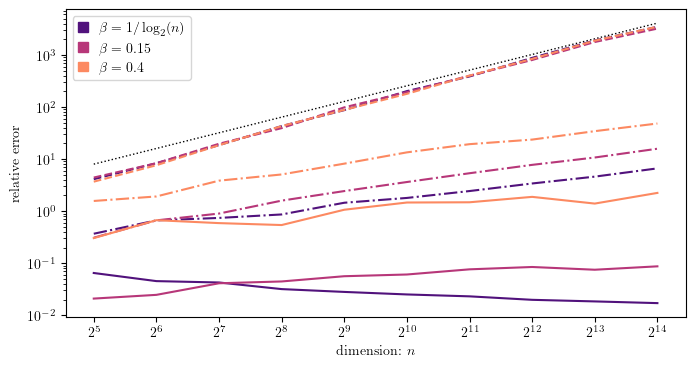

In [4]:
fig,axs = plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.1)

axs.plot(2**Ns,2**Ns/4,ls=':',lw=1,color='k')

handles = []
for j in range(len(βs(1))):

    c = plt.cm.magma((j+1)/(len(βs(1))+1))
    β = '1/\log_2(n)' if j==0 else βs(1)[j] 
    
    axs.plot(2**Ns,np.mean(errs['GN1'][:,j]/err_opt[:,None]-1,axis=1),color=c)
    #ax.plot(1/βs,np.mean(errs['GN2'][i]/err_opt[i]-1,axis=1),color=c,ls=':')
    axs.plot(2**Ns,np.mean(errs['RSVD1'][:,j]/err_opt[:,None]-1,axis=1),color=c,ls='--')
    axs.plot(2**Ns,np.mean(errs['RSVD2'][:,j]/err_opt[:,None]-1,axis=1),color=c,ls='-.')


    handles.append(mpatches.Circle((0,0),.5,color=c,label=rf'$\beta={β}$'))

axs.legend(handles=handles,loc='upper left',handlelength=0.7)

axs.set_xlabel('dimension: $n$')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xticks(2**Ns)
axs.xaxis.set_tick_params(which='minor',bottom=False)
axs.set_xticklabels([rf'$2^{{{N}}}$' for N in Ns])

axs.set_ylabel('relative error')

plt.savefig('imgs/exponential_growth.pdf')